# CoLeaf CNN

In [6]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import torch

In [7]:
TRAIN_SPLIT = 0.8
DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Overview of the dataset
The dataset consists of images of coffee leaves with varios nutrient deficiencies.

In [2]:
dataset_path = "./CoLeaf DATASET"
output_path = "./output/graphs"
os.makedirs(output_path, exist_ok=True)

# Get classes names and images per class
classes = [d for d in os.listdir(dataset_path)]

images = []
for c in classes:
    c_dir = os.path.join(dataset_path, c)
    images.append(len([f for f in os.listdir(c_dir)]))

df = pd.DataFrame({"Class": classes, "Number of images": images})
display(df)

,Class,Number of images
0,boron-B,101
1,calcium-Ca,162
2,healthy,6
3,iron-Fe,65
4,magnesium-Mg,79
5,manganese-Mn,83
6,more-deficiencies,104
7,nitrogen-N,64
8,phosphorus-P,246
9,potasium-K,96


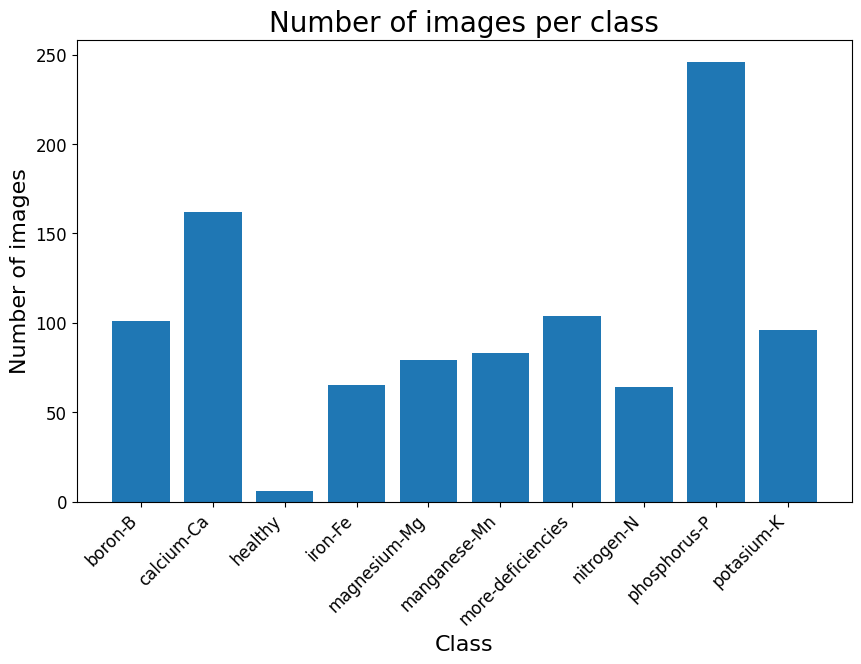

In [3]:
# Plot number of images per class
plt.figure(figsize=(10, 6))
bars = plt.bar(classes, images)
plt.title("Number of images per class", fontsize=20)
plt.xlabel("Class", fontsize=16)
plt.ylabel("Number of images", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(os.path.join(output_path, "images_per_class.png"))
plt.show()